In [45]:
import pandas as pd

df = pd.read_csv('label.csv',index_col=0)
df

,input,output
0,dataset/0.png,dataset/0_mask.png
1,dataset/1.png,dataset/1_mask.png
2,dataset/10.png,dataset/10_mask.png
3,dataset/100.png,dataset/100_mask.png
4,dataset/1000.png,dataset/1000_mask.png
...,...,...
3059,dataset/995.png,dataset/995_mask.png
3060,dataset/996.png,dataset/996_mask.png
3061,dataset/997.png,dataset/997_mask.png
3062,dataset/998.png,dataset/998_mask.png


In [46]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, csv_file, train_transform=None,test_transform = None):
        self.data = pd.read_csv(csv_file)
        self.train_transform = train_transform
        self.test_transform = test_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_path = self.data.input[index]
        output_path = self.data.output[index]
        input = Image.open(input_path).convert('RGB')
        output = Image.open(output_path).convert('RGB')
        if self.train_transform:
            input = self.train_transform(input)
        if self.test_transform:
            output = self.test_transform(output)
        return input, output

In [47]:
import torch
from torchvision import transforms
import torchvision

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.225, 0.225, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.225])
])

dataset = MyDataset('label.csv', train_transform=transform,test_transform=mask_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [2500, len(dataset)-2500])
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_set,batch_size=8, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device used: ',device)

device used:  cuda


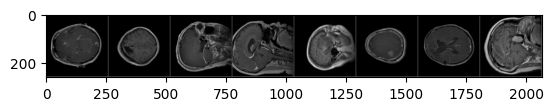

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
into, out = next(iter(train_dataloader)) 
pic = torchvision.utils.make_grid(into)
imshow(pic)

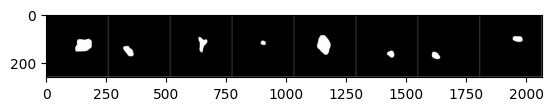

In [49]:
pic = torchvision.utils.make_grid(out)
imshow(pic)

In [50]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.enc1 = UNet.encoder_decoder_block(input_channels=3,output_channels=32)
        self.enc2 = UNet.encoder_decoder_block(input_channels=32,output_channels=64)
        self.enc3 = UNet.encoder_decoder_block(input_channels=64,output_channels=128)
        self.enc4 = UNet.encoder_decoder_block(input_channels=128,output_channels=256)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet.encoder_decoder_block(input_channels=256,output_channels=512)

        self.upconv1 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.upconv2 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.upconv3 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.upconv4 =  nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=2,stride=2)

        self.dec1 = UNet.encoder_decoder_block(input_channels=512,output_channels=256)
        self.dec2 = UNet.encoder_decoder_block(input_channels=256,output_channels=128)
        self.dec3 = UNet.encoder_decoder_block(input_channels=128,output_channels=64)
        self.dec4 = UNet.encoder_decoder_block(input_channels=64,output_channels=32)

        self.final_conv = nn.Conv2d(in_channels=32,out_channels=1,kernel_size=1)

        
    def forward(self, x):
        #encoding
        encoding1 = self.enc1(x)
        encoding2 = self.pool1(encoding1)
        encoding2 = self.enc2(encoding2)
        encoding3 = self.pool2(encoding2)
        encoding3 = self.enc3(encoding3)
        encoding4 = self.pool3(encoding3)
        encoding4= self.enc4(encoding4)
        bottleneck = self.pool4(encoding4)

        bottleneck = self.bottleneck(bottleneck)
        #decoding and concat
        decoding1 = self.upconv1(bottleneck)
        decoding1 = torch.cat((decoding1, encoding4), dim=1)
        decoding1 = self.dec1(decoding1)

        decoding2 = self.upconv2(decoding1)
        decoding2 = torch.cat((decoding2, encoding3), dim=1)
        decoding2 = self.dec2(decoding2)

        decoding3 = self.upconv3(decoding2)
        decoding3 = torch.cat((decoding3, encoding2), dim=1)
        decoding3 = self.dec3(decoding3)

        decoding4 = self.upconv4(decoding3)
        decoding4 = torch.cat((decoding4, encoding1), dim=1)
        decoding4 = self.dec4(decoding4)

        ans = torch.sigmoid(self.final_conv(decoding4))
        return ans


    @staticmethod
    def encoder_decoder_block(input_channels,output_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels,out_channels=output_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_features=output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=output_channels,out_channels=output_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_features=output_channels),
            nn.ReLU(inplace=True),
        )

In [51]:
model = UNet().to(device)
model

# model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5).to('cuda')
# model

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [52]:
import torch.optim as optim
from torchmetrics.classification import Dice

optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss().to(device)

In [53]:
n_epochs = 50
print_every = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)

model.to(device)

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (inp, out) in enumerate(train_dataloader):
        inp, out = inp.to(device), out.to(device)
        
        optimizer.zero_grad()
        outputs = model(inp)
        loss = criterion(outputs, torch.sigmoid(out))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx%100==0):
            print("Loss=",running_loss/(batch_idx+1))
            
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {(running_loss/total_step):.4f}')
    batch_loss = 0
    with torch.no_grad():
        model.eval()
        for inp, out in (val_dataloader):
            inp, out = inp.to(device), out.to(device)
            outputs_t = model(inp)
            loss_t = criterion(outputs_t, torch.sigmoid(out))
            batch_loss += loss_t

        val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {(batch_loss/len(val_dataloader)):.4f}')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'unet_model2.pt')
            print('Improvement-Detected, save-model')

    model.train()

Epoch 1

Loss= 0.5912061333656311
Loss= 0.3567652708232993
Loss= 0.3515827377044146
Loss= 0.3490481176645653

train-loss: 0.3489
validation loss: 0.3449
Improvement-Detected, save-model
Epoch 2

Loss= 0.33749306201934814
Loss= 0.3429576548019258
Loss= 0.34275265149216155
Loss= 0.3420649918408885

train-loss: 0.3421
validation loss: 0.3426
Improvement-Detected, save-model
Epoch 3

Loss= 0.34643465280532837
Loss= 0.3407825668259422
Loss= 0.3401889642376212
Loss= 0.3396143430095178

train-loss: 0.3395
validation loss: 0.3398
Improvement-Detected, save-model
Epoch 4

Loss= 0.3349892497062683
Loss= 0.33826043139589895
Loss= 0.3380182137833306
Loss= 0.33772315782962053

train-loss: 0.3377
validation loss: 0.3381
Improvement-Detected, save-model
Epoch 5

Loss= 0.33114075660705566
Loss= 0.33713236864250484
Loss= 0.3364472925959535
Loss= 0.33646842213564143

train-loss: 0.3365
validation loss: 0.3396
Epoch 6

Loss= 0.3365219831466675
Loss= 0.3360855434790696
Loss= 0.33534358345454013
Loss= 0.33

KeyboardInterrupt: 

In [54]:
input,output = next(iter(val_dataloader))

In [55]:
pic = model.to('cpu')(input)

In [64]:
into, out = next(iter(train_dataloader)) 
pic = torchvision.utils.make_grid(into)
imshow(pic[0])
print(into.size())

ValueError: axes don't match array

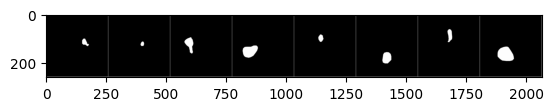

torch.Size([3, 260, 2066])

In [60]:
pic = torchvision.utils.make_grid(out)
imshow(pic)
pic.shape

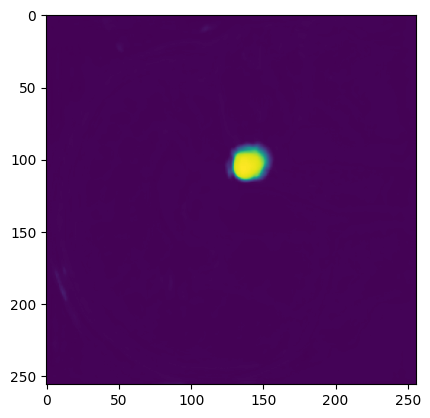

In [63]:
model.to('cpu')
pic = model(input)
imshow(pic.detach()[2])